In [1]:
import torch
from transformers import AutoTokenizer
from albert.embeddings import EmbeddingSummation
from torch.utils.data import DataLoader

In [2]:
train = pd.read_excel('Data_Train.xlsx')
test = pd.read_excel('Data_Test.xlsx')

df = pd.concat([train, test], ignore_index=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7797 entries, 0 to 7796
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         7797 non-null   object 
 1   Author        7797 non-null   object 
 2   Edition       7797 non-null   object 
 3   Reviews       7797 non-null   object 
 4   Ratings       7797 non-null   object 
 5   Synopsis      7797 non-null   object 
 6   Genre         7797 non-null   object 
 7   BookCategory  7797 non-null   object 
 8   Price         6237 non-null   float64
dtypes: float64(1), object(8)
memory usage: 548.4+ KB


## Edition
```
'Paperback,– 10 Mar 2016' -> [Paperback, 10, 3, 2016 ]
```

In [4]:
edition = df.Edition.str.split(',').str
df['EditionType'] = edition[0]
df['EditionDate'] = edition[-1].str.replace('– ', '')

parsedDates = pd.to_datetime(df.EditionDate, errors='coerce')
df['EditionMonth'] = parsedDates.dt.month
df['EditionYear'] = parsedDates.dt.year
df['EditionDay'] = parsedDates.dt.day
df['EditionDay EditionMonth EditionYear EditionType EditionDate Edition'.split()].head()

df.drop(['EditionDate', 'Edition'], axis=1, inplace=True)

## Reviews and Ratings
First word to be extracted

In [5]:
ratingsTransform = lambda x: (math.log(1+x)/10) ** .5
reviewsTransform = lambda x: (x/5)**4

df.Reviews = df.Reviews.str.split().str[0].astype('float32').apply(reviewsTransform)
df.Ratings = df.Ratings.str.split().str[0].str.replace(',','').astype('float32').apply(ratingsTransform)

## Authors

In [6]:
def authorTransform(authors):
    x = authors.split(', ') # authors separated by commas
    x = x[:5] if len(x) > 5 else x # max length is 5
    x = [a for a in x if not a.isnumeric()] # exclude numeric names
    return x

def getAllAuthors(frame):
    authorMatrix = list(frame.Author.apply(authorTransform))
    return set(itertools.chain(*authorMatrix))

In [7]:
authors = list(df.Author.apply(authorTransform))
    
# drop the original author column
df.drop('Author', axis=1, inplace=True)

# Convert series of lists into a dataframe of columns
expanded_authors = pd.DataFrame(authors, columns=[f'Author{i+1}' for i in range(5)])

# assign new columns to the dataframe 
df = df.assign(**expanded_authors)

# replace the Nones in author_i columns by '0'
df.replace({None: 'NAN'}, inplace=True)

# get only common authors from train
trainAuthors = getAllAuthors(train)
testAuthors  = getAllAuthors(test)
commonAuthors = sorted(list(trainAuthors.intersection(testAuthors)))

authorMap = {key : i+2 for i, key in enumerate(commonAuthors)}
# padding is 1
authorMap['NAN'] = 1
for i in range(5):
    df[f'Author{i+1}'] = df[f'Author{i+1}'].apply(lambda x: authorMap.get(x, 0) )# unknown is zero

## Assigning float types

In [8]:
for col in 'EditionDay EditionMonth EditionYear Price Reviews Ratings'.split():
    df[col] = df[col].astype(float)
df.dtypes

Title            object
Reviews         float64
Ratings         float64
Synopsis         object
Genre            object
BookCategory     object
Price           float64
EditionType      object
EditionMonth    float64
EditionYear     float64
EditionDay      float64
Author1           int64
Author2           int64
Author3           int64
Author4           int64
Author5           int64
dtype: object

## Genre and BookCategory

In [9]:
def encodeLabel(col):
    mask  = df.Price.isnull()
    test  = df[mask]
    train = df[~mask]
    
    common = set(train[col]).intersection(set(test[col]))
    common = sorted(list(common))
    colMap = {key: i+1 for i, key in enumerate(common)}
    df[col] = df[col].apply(lambda x: colMap.get(x, 0) ) # zero for unknown

In [10]:
for col in 'Genre BookCategory EditionType'.split():
    encodeLabel(col)

## Aggregating numerical variables w.r.t. categorical vars
We groupby each category and take min, max, mean, sum, median
General method
- Groupby column and aggregate using functions
- Rename cols
- Merge using df.merge(grouped, on='groupbycolname', how='left')

### Example
```
aggDict = {
    'name' : ['count'],
    'vals': ['mean','median','min','max','sum'],
    'kekw': ['mean','median','min','max','sum'],
}
toy = pd.DataFrame({
    'name' : pd.Series(list('112233') + [None, None]).astype(float),
    'vals' : np.arange(8),
    'kekw' : 42 * np.arange(8) + 69
})

# Groupby column and aggregate using functions
grouped = toy.groupby('name').agg(agg_func)

# Rename cols
grouped.columns = [f'name_{col}_{aggregator}' for col, aggregator in grouped.columns]

# Merge
toy.merge(grouped, on='name', how='left')
```

In [11]:
CATEGORICALS = 'Genre BookCategory EditionType EditionMonth EditionYear EditionDay'.split()
CATEGORICALS += [f'Author{i+1}' for i in range(5)]

aggDict = {
    'Ratings': ['mean','median','min','max','sum'],
    'Reviews': ['mean','median','min','max','sum'],
}

print("Aggregating... ", end='')
for col in CATEGORICALS:
    print(col, end=', ')
    # count occurance of each column
    aggDict[col] = ['count']
    
    # Groupby column and aggregate using functions    
    grouped = df.groupby(col).agg(aggDict)
    
    # Rename cols
    grouped.columns = ['_'.join([col, c, f]) for c, f in grouped.columns]

    # Merge using
    df = df.merge(grouped, on=col, how='left')
df.dtypes

Aggregating... Genre, BookCategory, EditionType, EditionMonth, EditionYear, EditionDay, Author1, Author2, Author3, Author4, Author5, 

Title                     object
Reviews                  float64
Ratings                  float64
Synopsis                  object
Genre                      int64
                          ...   
Author5_Author1_count      int64
Author5_Author2_count      int64
Author5_Author3_count      int64
Author5_Author4_count      int64
Author5_Author5_count      int64
Length: 192, dtype: object

## Title and synopsis 
- Use ALBERT embeddings to extract text features
- We sum the embeddings of each word to get the feature vector of the sentence 

In [12]:
def extractFeatures(series):
    loader = DataLoader(list(series), batch_size=32, shuffle=False)
    with torch.no_grad():
        outputs = []
        for sentences in tqdm(loader):
            batch = tokenizer(sentences, **tokenizer_args)
            out = model(batch['input_ids'], batch['attention_mask'])
            outputs.append(out)
    return torch.cat(outputs, dim=0).numpy()

print("Loading embeddings...")
model = EmbeddingSummation().eval()
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')
tokenizer_args = dict(return_tensors='pt', return_token_type_ids=False,
                                    padding=True, max_length=512, truncation=True)

print("Extracting title features..")
titleFeatures = extractFeatures(df.Title)
# assign title features
df = df.assign(**{
    f'TitleFeatures{i+1}': titleFeatures[:,i]
    for i in range(128) 
})

print("Extracting synopsis features..")
synopsisFeatures = extractFeatures(df.Synopsis)
# assign synopsis features
df = df.assign(**{
    f'SynopsisFeatures{i+1}': synopsisFeatures[:,i]
    for i in range(128) 
})

# drop str cols
df.drop(['Title', 'Synopsis'], axis=1, inplace=True)

Loading embeddings...
Extracting title features..



Extracting synopsis features..


In [13]:
df.dtypes.to_csv('DtypesAfterPreprocess.csv')

In [14]:
isTest = df.Price.isnull()
train = df[ ~ isTest ].reset_index(drop=True)
test =  df[isTest].reset_index(drop=True)

train.Price = np.log1p(train.Price.astype(float))

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Columns: 446 entries, Reviews to SynopsisFeatures128
dtypes: float32(256), float64(131), int64(59)
memory usage: 15.1 MB


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Columns: 446 entries, Reviews to SynopsisFeatures128
dtypes: float32(256), float64(131), int64(59)
memory usage: 3.8 MB


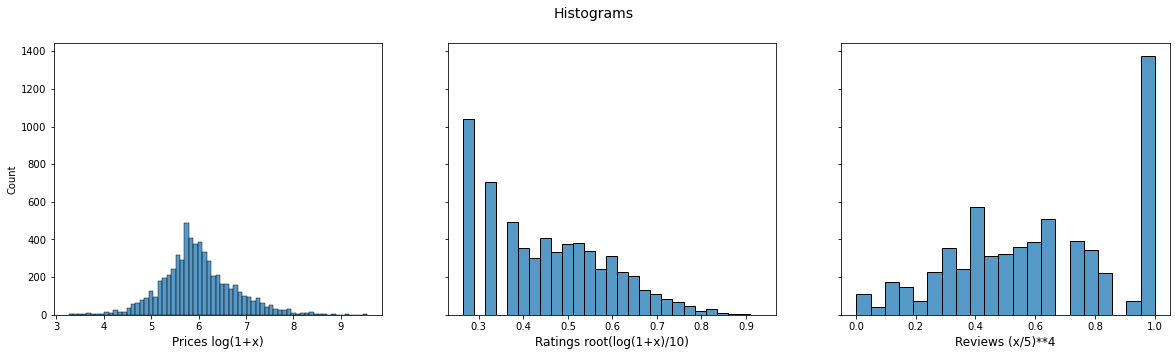

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
plt.suptitle('Histograms', fontsize=14)

sns.histplot(train.Price, ax=ax1)
ax1.set_xlabel('Prices log(1+x)', fontsize=12);

sns.histplot(train.Ratings, ax=ax2)
ax2.set_xlabel('Ratings root(log(1+x)/10)', fontsize=12)

sns.histplot(train.Reviews, ax=ax3)
ax3.set_xlabel('Reviews (x/5)**4', fontsize=12);